### Content Library Product Cannibalization & Value Added Case Study
#### An Advanced Analytics (AA) Study by Dan Colarusso

#### Purpose & Background:

##### At my previous role at Gerson Lehrman Group (GLG), the company offered subscriptions with varying usage rules and caps to access our network of 'Experts' across a suite of products: calls, events, custom studies, and eventually professionally curated library content. Library content is bundled with a premium subscription option. Contract pricing is based on a model of rules such as: active users, region, business unit, etc. 

##### While on the Advanced Analytics team (AA), a group of stakeholders approached AA with requests for their business questions for their long term strategy & requested Enterprise Data resources for their initaitive in their 2.0 complete rebranding. GMs voiced concerns with the library team that an increase in library product usage led to decreases in call (the biggest product offering in terms of usage) & other product types usage.

##### Further, there were additional questions from the members of the leadership team surrounding the average value increaed or decreased to a client contract when the library add-on was subscribed from usage deltas of the other product. In summary, they were concerned about the stability of the future of the library product as they headed into a complete product relaunch. Is it work allocating additional resources to the product if it will eat away resources from other products or not able to turn a profit in the long run with minimal value added?

#### Main Audience:
##### VP of Library Content - Both Projects
##### VP of Events, Americas - Both Projects
##### SVP, Global Head of Content & Events - Both Projects
##### General Manager, EMEA Region - Cannibalization
##### Head of Americas - Value Added
##### CFO - Value Added

#### Approach:
##### Leverage a data science project pipeline to answer the hypotheses "There is no product cannibalization when a client has a library subscription" and "Does there exist is a measurable lift to all product usage such that we can ask for a higher contract price at the end of a contract cycle?" starting from project intake all the way to recommended insights & BI deliverables used to monitor results in real-time.

#### Results:
##### We can accept both hypotheses as true. Through correlations used in linear regressions, library usage has moderate correlation levels with other product usage for clients with a library sub. Then with a trained linear regression model, we can attribute ~+10% additional projects done yielding an additional ask of y dollars in a contract.

## <a id ='back'> Outline </a>
### [Creating the Data](#create)

##### We use a python script to create a dimensonal table for client information. This table will hold contract type, the business unit, and region for a size n clients of our chosing. We use weighted probabilities that best reflects the real world distribution of client characteristics. From this client table, we then an additional py function to generate a facts table for product usage. As before, the usage patterns attempt to reflect actual usage. We then join on unique client ids to create a full usage table.

#### NOTE:
##### As this is dummy data, this isn't a perfect represtation. There's some nuance to contract types that are tough to reflect with dummy data; legacy rules, the ability for larger firms to negotiate special terms, capping rules, subsidiaries, etc. For this case study, we'll leave it untouched as possible. 

##### Actual SQL query utilized a series of CTEs pulling from a client dimension table with joins to facts table to get usage by month, allowing us to generate the nulls needed to impute to zeroes. We then left join all the CTEs together with the same client table to tie in necessary client data.

### [Exploratory Data Analysis](#eda)
##### With our dummy data ready, we can look at distributions of quantitative variables in histograms. We see pareto distributions prevelant throughout the data from usage patterns to active user bases. This is a very common pattern. Only a small % of users will generate the majority of our business. These tails are long enough to push the mean ~1/2 of the standard deviation ahead of the medians for usage. 

##### We can use crosstabulation in Pandas to examine significance between categorical variables and target variable (all usage). We can use kernel density plots to get an eyeball comparison between the usage probability and clients with & without library subs. Even bar plots to show median usage between library types begins to show a potential picture of statistical significance between these groups. We'll also want to quickly check for potential or underlying seasonality in the usage patterns. A simple visual will suffice in this use case as opposed to a formal time series method such as deploying an ARIMA model.

### [Data Transformation & Model Prep](#prep)
##### If they exist, we'll need to impute nulls and address duplicated entries in the tables. For sake of simplicity, we'll assume no outliers to take in account length of the case study (however, this is NOT best data practices and there are plenty of packages to deal with outliers).

##### We have two data problems too account for before we begin training models. First, a transformer needs to be applied to the quantitative data in order to scale down to something resembling normally distributed data. This will make the data easier to digest for linear or more sophisticated ML models. Second, we'll need to encode categorical to dummy variables. We will construct a ColumnTransformer pipeline to run both processes in one go.

##### We'll also need to check for co-variance and variance inflation. If one of the variables is inflating the behavior of another, we'll need to check by how much so and then drop it prior to training models. We may also drop categorical variables with chi-squared values against the target variable that do not meet the standard p values of statistical significance. 

##### As part of the exhaust of checking for variance inflation and correlations, we can answer the hypothesis of product cannibalization. Running any type of model requires independent variables. By this definition, we are examine cannibalization. If cannibalization exists, we would see negative correlation values. Then, any type of regression or modeling work would have to stop or be adjusted. 

### [Modeling Training & Running](#train)
##### The right tool for the right job. We'll start off as simple as we can with training on a subset of our data before testing on the omitted data. If need be, we can try out a more sophisticated model or ML model if a linear regression turns up empty handed or yields unreliable results (and NOT results we simply don't like). In each case, we can apply a tool such as a folded GridSearch to tune our hyperparameters to produce a higher quality model.

##### With hyperparameters selected based on its highest accuracy score and confirmed no overfitting exists with test data, we can run a formal test by creating additional client dimension and usage facts. We will assume no library contracts first to see the all usage median, then re-run to compare a median with library enabled. Combined with the integrity of a proper data science model (and assuming it passed code & project review), we can ultimately answer the question on added value. 

In [1]:
#
#
#

### Recommended Action Items & Continuing Improvement
##### With exhaust from the regression by checking linear independence, we can provide answers to the GMs and actively watch for cannibalization through Looker dashboards. We can also take a step back and build a table to watch for cannibalization on a per client basis.

##### Using the value added model, we can go back to LT with preliminary dollar figures to allocate a bit more resources and to demonstrate enterprise value for library 2.0. Monitoring results will be difficult to be done in Looker due to trying to account for run times against Airflow orchestration schedules, but we can store and log these values within Hex or potentially into a staging table. Either way, enterprise data can have these numbers on hand to easily watch how the projected and actual delta changes as more clients sign on by the needed grains.

##### Now that we have a method of aggregating usage data that can be tied with client information, we can perform analyses such as clustering or segmentation. We can begin to answer questions such as what profiling makes a client more likely to purchase a library sub? What makes one less likely and are there gaps we can fix to increase the likelihood? For example, we then build a K-Means model to bucket clients into usage tiers. Leveraging funnel metrics, we discovered Health & Bio firms were conducting searches for content, but didn't download or even click on anything. Mimicing what they were searching for, we discovered we weren't curating their demand.

### <a id='create'> Creating the Data </a>
#### [Back to Top](#back)

In [2]:
#### import all of needed packages in one go. 
import pandas as pd
import numpy as np
from numpy.random import default_rng
from scipy.stats import chi2_contingency
from datetime import datetime, timedelta, date ###basic packages esp. for EDA

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler
from sklearn.compose import ColumnTransformer ### what we need for scaling and transformations

from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn import linear_model ### packages to tune and build models.

import statsmodels.formula.api as smf ##residual plotting

import matplotlib.pyplot as plt
import seaborn as sns ## visualization packages.

In [3]:
###create dummy client data as a dimension table.
def make_client_table(size):
    business_unit = ['Professional Services', 'Healthcare', 'Private Equity', 'Industrials', 'Technology']
    region = ['Americas', 'EMEA'] 
    contract_type = ['OSP', 'OSP-Cap', 'C-OSP']
    library_sub = [True, False]
    rng = default_rng()

    df = pd.DataFrame({
        'client_id' : rng.choice(99999, size=size, replace=False),
        'business_unit' : [np.random.choice(business_unit) for i in range(size)],
        'region' : [np.random.choice(region, p=[0.70, 0.30]) for i in range(size)],
        'contract_type' : [np.random.choice(contract_type, p=[0.50, 0.25, 0.25]) for i in range(size)],
        'library_sub' : [np.random.choice(library_sub, p=[0.33, 0.67]) for i in range(size)],
        'active_users' : np.ceil([ (np.random.pareto(2.75)) * 1 for i in range(size)]) 
    })   

    return df

size = 6000
d_client = make_client_table(size)

In [4]:
##then, fill in a usage facts table based off of our client table.
total_months = 24
data = []
end_date = datetime.today().strftime('%Y-%m-%d')
start_date = (datetime.today() - timedelta(days=30*total_months)).strftime('%Y-%m-%d')
months = pd.period_range(start=start_date, end=end_date, freq='M')

for i in list(d_client.client_id):
    for month in months:
        if d_client.loc[d_client['client_id'] == i]['region'].iloc[0] == 'Americas':
            call_usage = (d_client.loc[d_client['client_id'] == i]['active_users'].iloc[0] * np.random.logseries(0.6, 1) )
            events_usage = (d_client.loc[d_client['client_id'] == i]['active_users'].iloc[0] * np.random.logseries(0.5, 1) )
            library_usage = (d_client.loc[d_client['client_id'] == i]['active_users'].iloc[0] * np.random.logseries(0.3, 1) )
            other_usage = (d_client.loc[d_client['client_id'] == i]['active_users'].iloc[0] * np.random.logseries(0.2, 1) )
            data.append([i, month, call_usage, events_usage, library_usage, other_usage]) 
        elif d_client.loc[d_client['client_id'] == i]['region'].iloc[0] == 'EMEA':
            call_usage = (d_client.loc[d_client['client_id'] == i]['active_users'].iloc[0] * np.random.logseries(0.55, 1))
            events_usage = (d_client.loc[d_client['client_id'] == i]['active_users'].iloc[0] * np.random.logseries(0.3, 1) )
            library_usage = (d_client.loc[d_client['client_id'] == i]['active_users'].iloc[0] * np.random.logseries(0.5, 1) )
            other_usage = (d_client.loc[d_client['client_id'] == i]['active_users'].iloc[0] * np.random.logseries(0.2, 1) ) 
            data.append([i, month, call_usage, events_usage, library_usage, other_usage]) 

df = pd.DataFrame(data, columns = ['client_id', 'month', 'call_usage', 'events_usage', 'library_usage', 'other_usage'])

In [5]:
for i in df.select_dtypes(include='object'):
    df[i] = df[i].astype('float64')
f_usage = df.merge(d_client, on='client_id', how='left')

f_usage

,client_id,month,call_usage,events_usage,library_usage,other_usage,business_unit,region,contract_type,library_sub,active_users
0,84030,2021-07,1.0,2.0,1.0,1.0,Private Equity,EMEA,OSP,False,1.0
1,84030,2021-08,4.0,1.0,1.0,1.0,Private Equity,EMEA,OSP,False,1.0
2,84030,2021-09,1.0,3.0,2.0,1.0,Private Equity,EMEA,OSP,False,1.0
3,84030,2021-10,1.0,1.0,1.0,1.0,Private Equity,EMEA,OSP,False,1.0
4,84030,2021-11,1.0,1.0,1.0,1.0,Private Equity,EMEA,OSP,False,1.0
...,...,...,...,...,...,...,...,...,...,...,...
149995,83125,2023-03,2.0,10.0,2.0,2.0,Industrials,Americas,OSP-Cap,False,2.0
149996,83125,2023-04,4.0,2.0,2.0,2.0,Industrials,Americas,OSP-Cap,False,2.0
149997,83125,2023-05,2.0,2.0,2.0,2.0,Industrials,Americas,OSP-Cap,False,2.0
149998,83125,2023-06,2.0,2.0,2.0,2.0,Industrials,Americas,OSP-Cap,False,2.0


In [6]:
### apply multpliers roughly mimicing real life usage patterns between BUs and regions
def multipliers(df):
    df.loc[(df.library_sub == True) & (df.active_users <= 5), 'call_usage'] = df.loc[(df.library_sub == True) & (df.active_users <= 5), 'call_usage'] * 1.75
    df.loc[(df.library_sub == True) & (df.active_users <= 5), 'events_usage'] = df.loc[(df.library_sub == True) & (df.active_users <= 5), 'events_usage'] * 1.50
    df.loc[(df.library_sub == True) & (df.active_users <= 5), 'other_usage'] = df.loc[(df.library_sub == True) & (df.active_users <= 5), 'other_usage'] * 1.50
    df.loc[(df.library_sub == True) & (df.active_users > 5), 'call_usage'] = df.loc[(df.library_sub == True) & (df.active_users > 5), 'call_usage'] * 1.20
    df.loc[(df.library_sub == True) & (df.active_users > 5), 'events_usage'] = df.loc[(df.library_sub == True) & (df.active_users > 5), 'events_usage'] * 1.10
    df.loc[(df.library_sub == True) & (df.active_users > 5), 'other_usage'] = df.loc[(df.library_sub == True) & (df.active_users > 5), 'other_usage'] * 1.10
    ## Here, we make a series of .loc statements. While we can do it with less code with an interrows function, it is inadvisable to do so.
    ## Iterrows function if quite computationally taxing on the cpu. The machine will run python scripts on each row, interatively. 
    ## Whereas using .loc will splice in the df and run in one go. 

    df.loc[( ((df.business_unit == 'Professional Services') | (df.business_unit == 'Private Equity' ))
          & (df.region == 'EMEA')), 'library_usage'
          ] = df.loc[( ((df.business_unit == 'Professional Services') | (df.business_unit == 'Private Equity' ))
          & (df.region == 'EMEA')), 'library_usage'
          ] * 1.25    

    df.loc[( (df.business_unit == 'Professional Services') & (df.region == 'Americas')), 'library_usage'
           ] = df.loc[( (df.business_unit == 'Professional Services') & (df.region == 'Americas')), 'library_usage'
           ] * 0.50       

    df.loc[( ((df.business_unit == 'Healthcare') | (df.business_unit == 'Private Equity' ))
             & (df.region == 'Americas')), 'library_usage'
           ] = df.loc[( ((df.business_unit == 'Healthcare') | (df.business_unit == 'Private Equity' ))
             & (df.region == 'Americas')), 'library_usage'
           ] * 1.25       

    df.loc[df['library_sub'] == False, 'library_usage'] = df.loc[df['library_sub'] == False, 'library_usage'] * 0.10     

multipliers(f_usage)

### <a id = 'eda'> Exploratory Data Analysis </a>
#### [Back to Top](#back)

#### Relevant Stakeholder Notes from Intake Meetings

##### According to client surveys and feedback, clients are impressed with the quality of content hosted in the library. Clients view the content as higher quality relative to the competition and is trusted in strategic decision making. One of the biggest areas for improvement is increasing the volume of content available. However, clients state they feel more compelled to do additional work with us. They view the suite of products as tools in a bigger kit rather being siloed into a set number of uses. In other words, if they are impressed with library quality, they would approach us to call an expert for a different project.

##### There's variance in usage in terms of Region + Business unit. One like BU in EMEA will have different usage than in the Americas. According to client feedback, the current working theory is differance in client age and tenure. Older, more tenured client associates tend to be in the Americas and prefer the 1<>1 calls whereas EMEA will use library content for jr associates and as training materials esp. in more financial roles.

##### Finance has a semi working model for OSP Cap and C-OSP type subs due to how easily transactions are tracked within the general ledger. Their model shows modest lifts to overall usage, but there's uncertainity to the validity of the results. Project code in GitHub shows low scoring models. OSP contracts are a harder type to model due to the rules of the contract and how it get to the GL. However, all project + product usage is tracked.

In [7]:
f_usage.isnull().sum()

client_id        0
month            0
call_usage       0
events_usage     0
library_usage    0
other_usage      0
business_unit    0
region           0
contract_type    0
library_sub      0
active_users     0
dtype: int64

In [8]:
f_usage.duplicated().sum()

0

##### No nulls or dupes is great. Makes cleaning data that much easier. Now let's get a feel for the spread of the data.

##### As noted above, most of the nulls in actuals were really just zeroes for usage. The rest were just missing region data that can be imputed from the country data in the client data.

In [9]:
f_usage.drop(['client_id'], axis=1).describe()

,call_usage,events_usage,library_usage,other_usage,active_users
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,2.528245,2.029326,0.647807,1.655659,1.277500
std,2.884637,2.098863,1.175828,1.380372,0.934434
min,1.000000,1.000000,0.050000,1.000000,1.000000
25%,1.000000,1.000000,0.100000,1.000000,1.000000
50%,1.750000,1.500000,0.200000,1.000000,1.000000
75%,3.000000,2.000000,1.000000,1.500000,1.000000
max,126.000000,132.000000,84.000000,66.000000,22.000000


##### One immediate takeaway is the distance between the mean and the median. For some types, the distance is 1/2 of a standard dev. When we also consider max values, we should expect a long tail or large usage values esp. for bigger clients with a bigger active user base.

In [10]:
f_usage.dtypes

client_id            int64
month            period[M]
call_usage         float64
events_usage       float64
library_usage      float64
other_usage        float64
business_unit       object
region              object
contract_type       object
library_sub           bool
active_users       float64
dtype: object

##### Sum all usage types into one target column.

In [11]:
f_usage['all_usage'] = f_usage.call_usage + f_usage.events_usage + f_usage.library_usage + f_usage.other_usage

<Axes: xlabel='business_unit', ylabel='call_usage'>

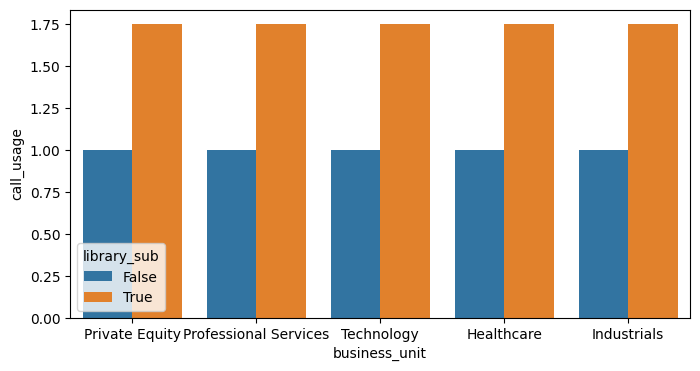

In [12]:
bar_fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(data=f_usage, x='business_unit', y='call_usage', hue='library_sub', estimator='median')

In [13]:
f_usage.groupby(['region', 'library_sub']
               ).agg({'active_users' : 'median',
                      'all_usage' : 'median',
                      'call_usage' : 'median',
                      'events_usage' : 'median',
                      'library_usage' : 'median'})

active_users  all_usage  call_usage  events_usage   
region   library_sub                                                      
Americas False                 1.0      4.125        1.00           1.0  \
         True                  1.0      7.500        1.75           1.5   
EMEA     False                 1.0      4.100        1.00           1.0   
         True                  1.0      7.500        1.75           1.5   

                      library_usage  
region   library_sub                 
Americas False                0.125  
         True                 1.250  
EMEA     False                0.125  
         True                 1.250

##### Plot a KDE to get a better read on the distribution of usage. We already know there's quite a distance between the mean and median which can reach a gap of 1/4 of a StDev for some product types.

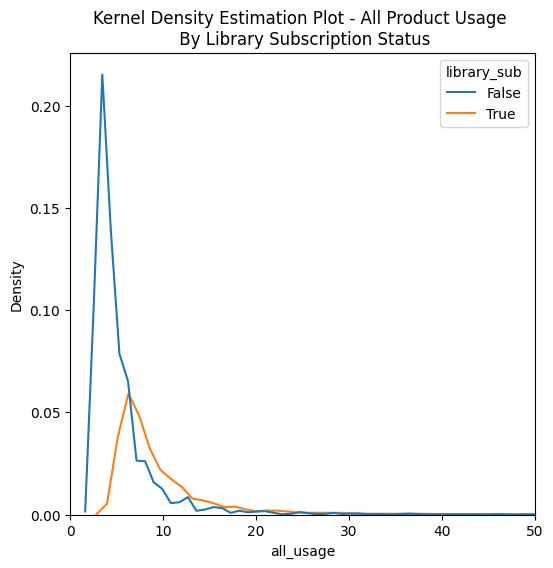

In [14]:
kde_fix, ax = plt.subplots(figsize=(6,6))
sns.kdeplot(data=f_usage, x='all_usage', hue='library_sub')
ax.set_xlim(left=0, right= 50)

plt.title('Kernel Density Estimation Plot - All Product Usage \n By Library Subscription Status')
plt.show()

##### Note the difference in the maximas for the curves. Library subs have probabilities of monthly all in usage greater than non. Non library clients are exhausting their probabilities of bigger usage patterns whereas library clients have a long, probability tail.

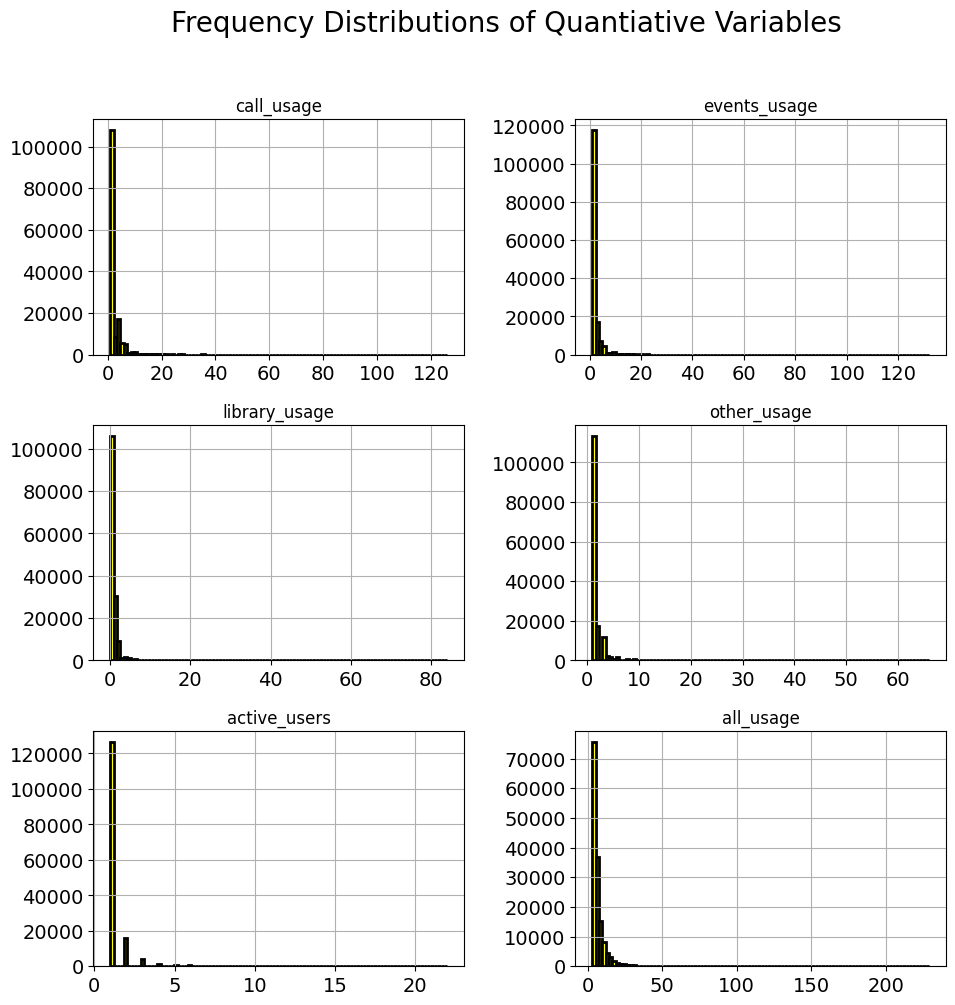

In [15]:
def make_histograms(df):
    histo = df.select_dtypes(include = ['float64'])
    histo.hist(figsize=(11,11), bins = 100, xlabelsize=14, ylabelsize=14
                , color='yellow', linewidth=2, edgecolor='black')

    plt.suptitle('Frequency Distributions of Quantiative Variables', fontsize=20)
    plt.show()

make_histograms(f_usage)

##### As expected, pretty drastic pareto distributions. However, we have the data tools to account for this & scale them to a different type when it's time to model the data for a regression.

##### Now, we begin to examine the relationships between our variables. First, we will examine the relationships between the continuous variables by heatmapping correlations for all library clients and then by those with subs and those without.

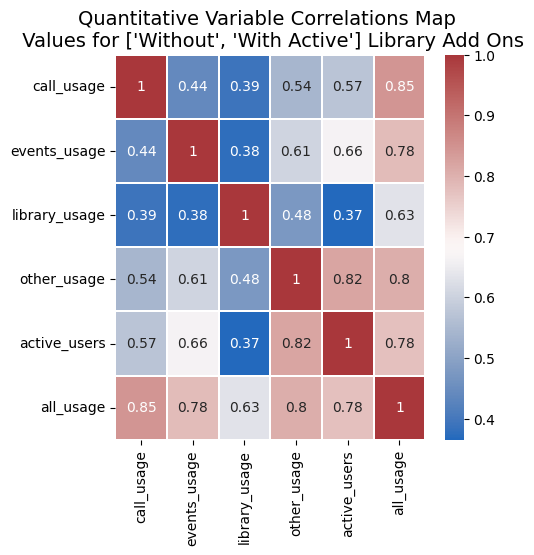

In [16]:
def make_correlations(df):
    corr_fig, ax = plt.subplots(figsize=(5,5))
    df_corr = sns.heatmap(df.select_dtypes(include = ['float64']).corr(), linewidth = 0.25, cmap='vlag', annot=True)
    a = list(pd.Series(df.library_sub.unique()).map({True: 'With Active', False : 'Without'}))
    plt.title('Quantitative Variable Correlations Map \n Values for ' + str(a) + ' Library Add Ons', fontsize = 14)
    plt.show()

make_correlations(f_usage)

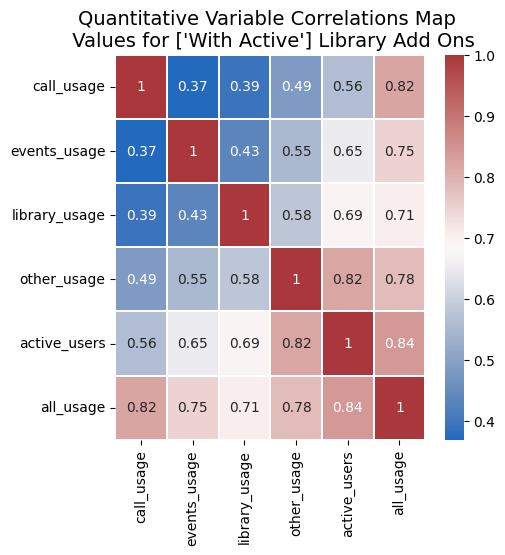

In [17]:
make_correlations(f_usage[f_usage.library_sub == True])

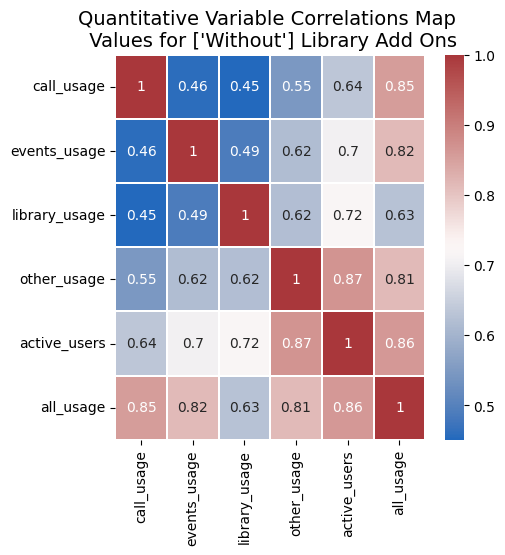

In [18]:
make_correlations(f_usage[f_usage.library_sub == False])

##### Now examine categorical variables

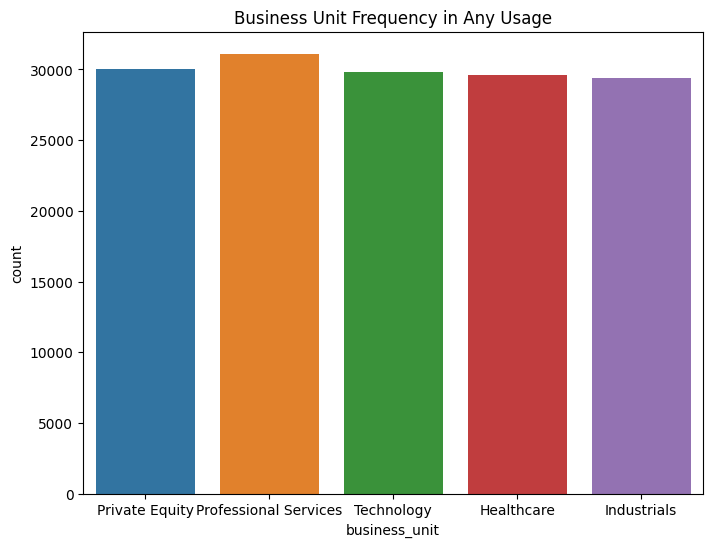

In [19]:
bu_plot, ax = plt.subplots(figsize=(8,6))
sns.countplot(data=f_usage.select_dtypes(include='object'), x = 'business_unit')

plt.title('Business Unit Frequency in Any Usage')
plt.show()

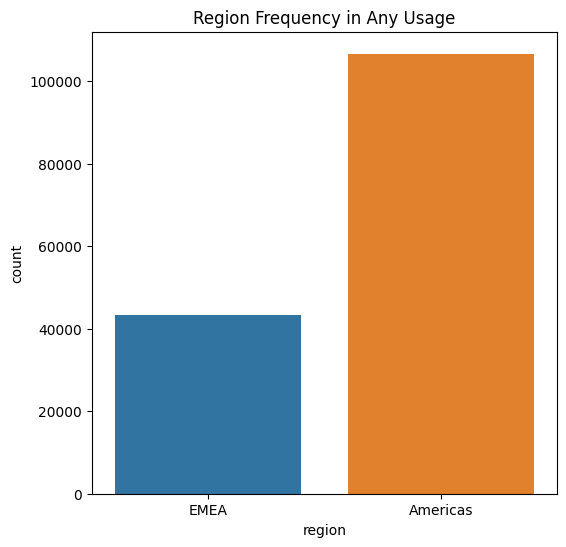

In [20]:
reg_plot, ax = plt.subplots(figsize=(6,6))
sns.countplot(data=f_usage.select_dtypes(include='object'), x = 'region')

plt.title('Region Frequency in Any Usage')
plt.show()

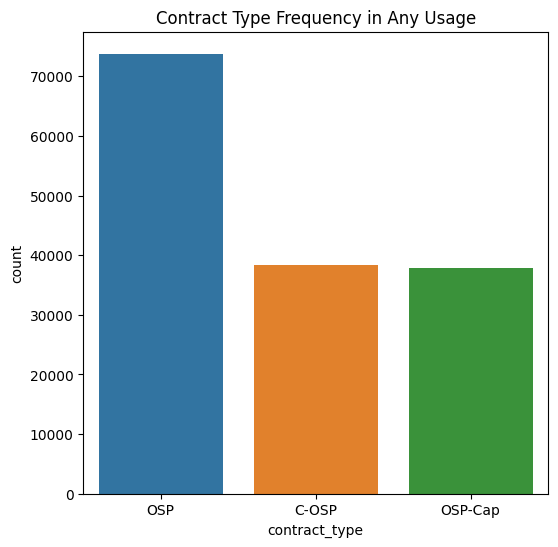

In [21]:
contract_fig, ax = plt.subplots(figsize=(6,6))
sns.countplot(data=f_usage.select_dtypes(include='object'), x = 'contract_type')

plt.title('Contract Type Frequency in Any Usage')
plt.show()

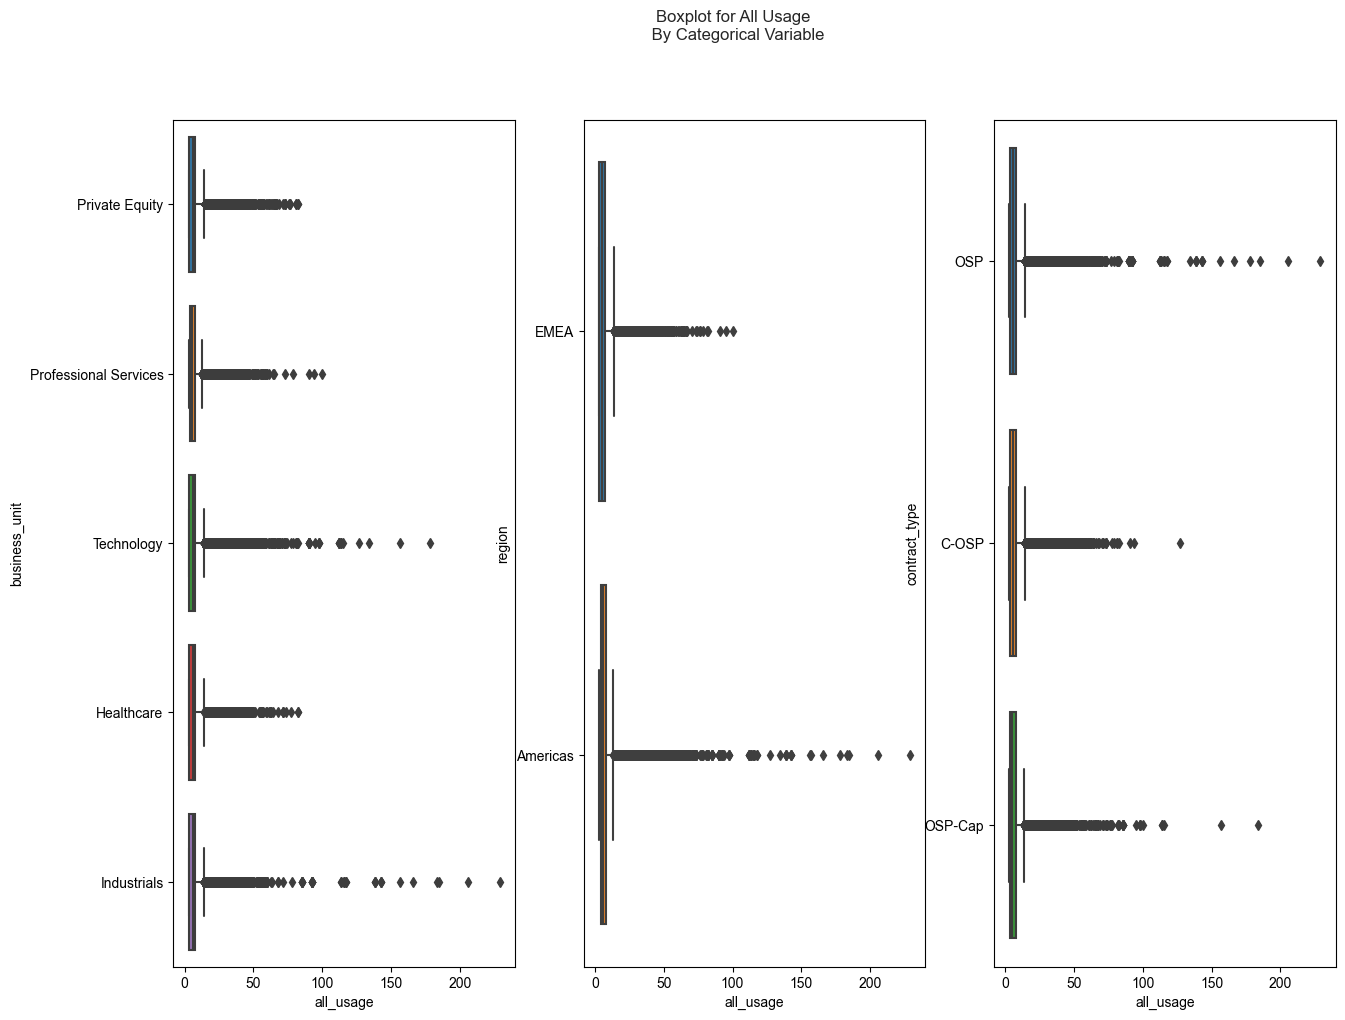

In [22]:
cat_fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 11))
sns.set_style('white')
axes = axes.flatten() 

sns.boxplot(data=f_usage, x='all_usage', y='business_unit', ax=axes[0], orient='h')
sns.boxplot(data=f_usage, x='all_usage', y='region', ax=axes[1], orient='h')
sns.boxplot(data=f_usage, x='all_usage', y='contract_type', ax=axes[2], orient='h')

plt.suptitle('Boxplot for All Usage \n By Categorical Variable')
plt.show()

##### The massive tails even skew our boxplots. Lets cut this trim this back so we can visualize the first quartiles a bit better.

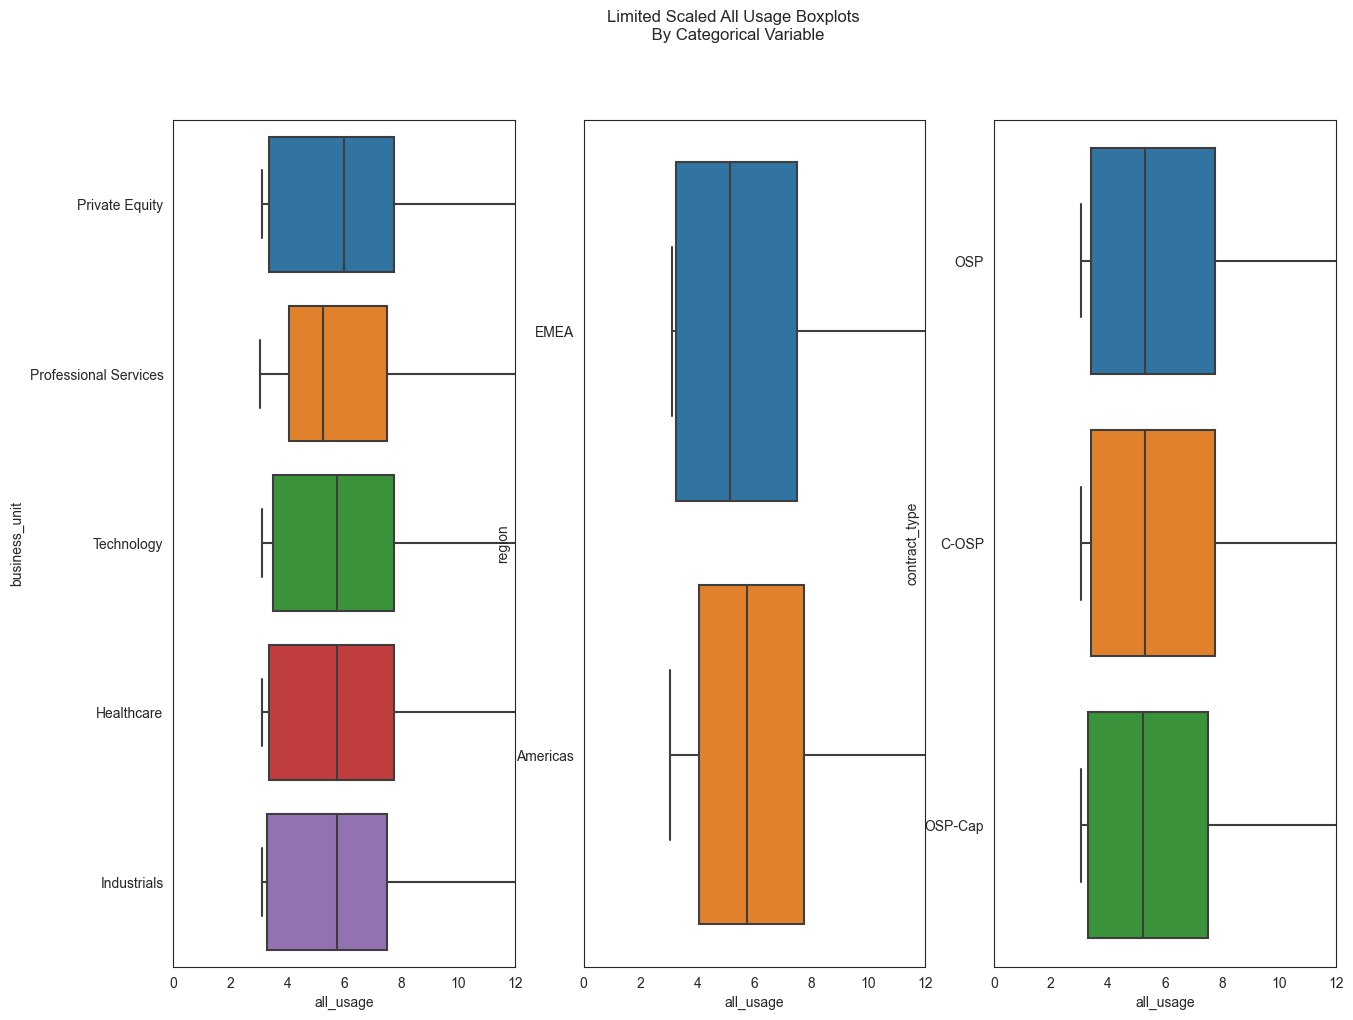

In [23]:
cat_fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,11))
sns.set_style('white')
axes = axes.flatten() 

sns.boxplot(data=f_usage, x='all_usage', y='business_unit', ax=axes[0], orient='h')
sns.boxplot(data=f_usage, x='all_usage', y='region', ax=axes[1], orient='h')
sns.boxplot(data=f_usage, x='all_usage', y='contract_type', ax=axes[2], orient='h')

for ax in axes:
    ax.set_xlim(left=0, right=12)

plt.suptitle('Limited Scaled All Usage Boxplots \n By Categorical Variable')
plt.show()

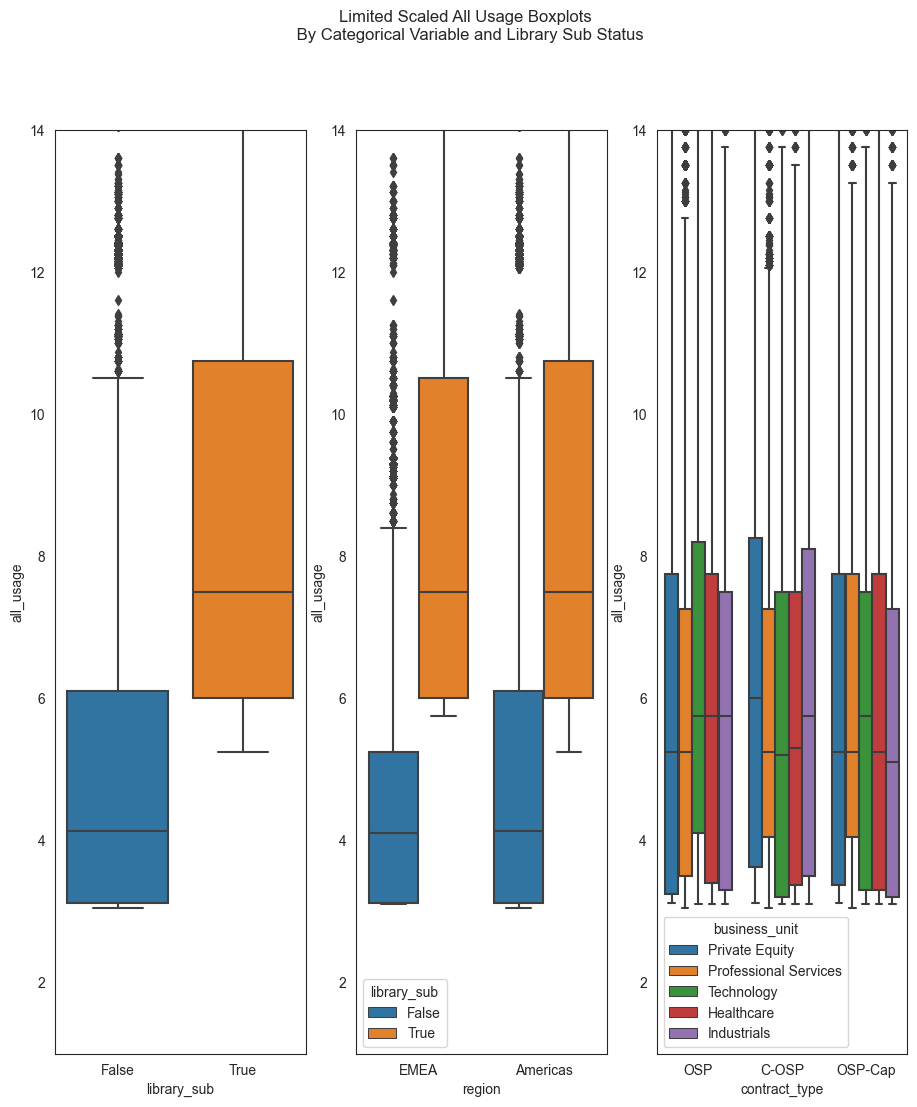

In [24]:
cat_fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(11,12))
sns.set_style('white')
axes = axes.flatten() 

sns.boxplot(data=f_usage, y='all_usage', x='library_sub', ax=axes[0])
sns.boxplot(data=f_usage, y='all_usage', x='region', ax=axes[1], hue='library_sub')
sns.boxplot(data=f_usage, y='all_usage', x='contract_type', ax=axes[2], hue='business_unit')

for ax in axes:
    ax.set_ylim(bottom=1, top=14)

plt.suptitle('Limited Scaled All Usage Boxplots \n By Categorical Variable and Library Sub Status')
plt.show()

##### Even with our categorical variables, our pareto all usage distributions still hold. The variance is so great we needed to limit the axis to examine the differences in the first three quartiles. Once narrowed, we see some subtle differences in usage across business units and regions.

##### Apply a chi-squared score to categorical variables to get a read on their importance to target variable through a cross-tab contigency table

In [25]:
csq_library = chi2_contingency(pd.crosstab(f_usage['all_usage'], f_usage['library_sub']))
print(csq_library[1])

0.0


In [26]:
csq_bu = chi2_contingency(pd.crosstab(f_usage['all_usage'], f_usage['business_unit']))
print(csq_bu[1])

0.0


In [27]:
csq_contract =chi2_contingency(pd.crosstab(f_usage['all_usage'], f_usage['contract_type']))
print(csq_contract[1])

5.834706025496586e-117


##### Now, we'll do a check for seasonality within usage patterns. Actuals was a bit more extensive, but for the sake of timing, we'll keep it to just the topline results.

In [28]:
agg_df = pd.pivot_table(data=f_usage, values=['call_usage', 'events_usage', 'library_usage', 'other_usage'],
               index = 'month', aggfunc='sum').reset_index()

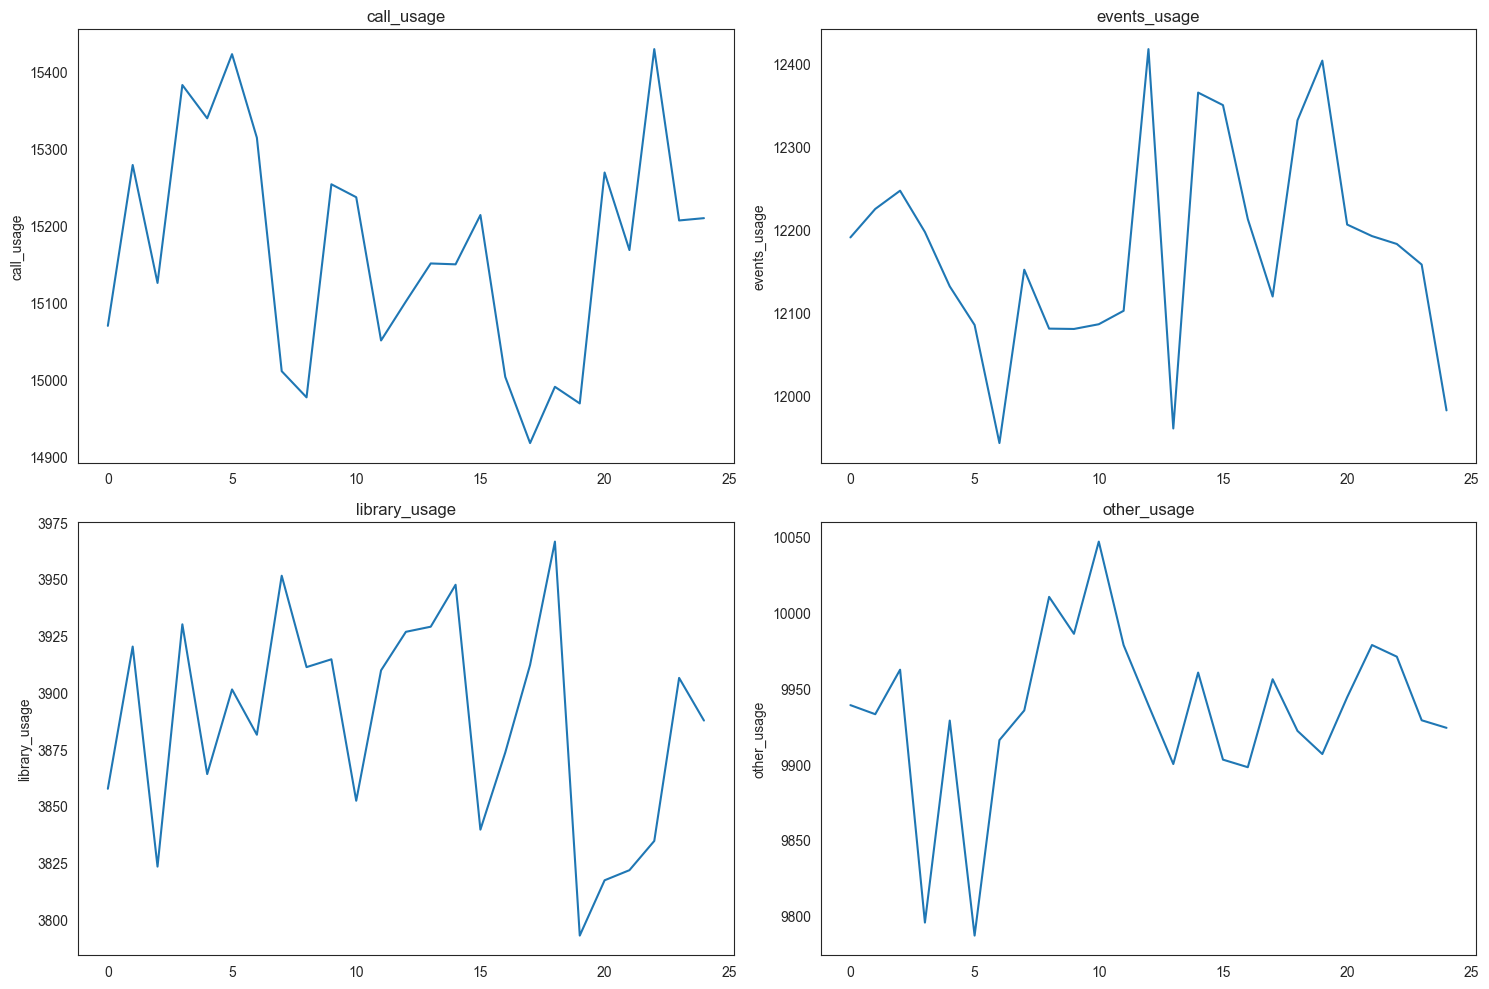

In [29]:
date_fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10)) 
axes = axes.flatten()

sns.set_style("white")

columns = list(agg_df.columns)[1:]
for i, column in enumerate(columns):
    sns.lineplot(data=agg_df, x=agg_df.index, y=column, ax=axes[i])
    axes[i].set_title(column)

plt.tight_layout()
plt.show()

##### Carefully note the axis values for each graph. Not only do we see a pattern of seasonality across the products, we see its variance pretty stable.

### <a id = 'prep'> Data Transformation and Scaling & Model Prep </a>
##### [Back to Top](#back)
##### Quick recap: usage types have a pareto/exponential distribution across all product types, categorical variables matter against target & target has pareto behavior with categorical vars, seasonality isn't present, linear independence exists with quant. variables

In [30]:
def calc_vif(df):
    X = df.select_dtypes(include='float64').drop(['all_usage'], axis=1)
    vif_df = pd.DataFrame()
    vif_df['features'] = X.columns
    vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

    return vif_df

calc_vif(f_usage)

,features,VIF
0,call_usage,2.806305
1,events_usage,3.626293
2,library_usage,1.798856
3,other_usage,8.466882
4,active_users,9.757783


##### Our target VIF is anything below a 5.0. Active users inflates the variance of the usage types. Let's rerun the VIF once more without active users & see if the others will drop below that mark. We'll also omit library usage as its only moderatly correlated with all usage. In our case, this is acceptable holistically since we're more concerned with the relationship with library subs and the other products. More so, including that usage may cause the model to become overfit

In [31]:
calc_vif(f_usage.drop(['library_usage', 'active_users'], axis=1))

,features,VIF
0,call_usage,2.526956
1,events_usage,3.059880
2,other_usage,3.835562


##### This is much better. All quantitative variables are within the acceptable variance inflation limit. We can use these as inputs in a model. For simplicity sake, let's just examine the hypothesis for OSP contracts and keep the model and touch simpler.

In [32]:
X = f_usage.drop(['all_usage', 'client_id', 'active_users', 'month', 'library_usage'], axis=1)
X['library_sub'] = X.library_sub.map(lambda x: 0 if x == False else 1)
y = f_usage[['all_usage']]

In [33]:
X.dtypes

call_usage       float64
events_usage     float64
other_usage      float64
business_unit     object
region            object
contract_type     object
library_sub        int64
dtype: object

In [34]:
quants = list(X.select_dtypes(include='float64').columns)
quals = list(X.select_dtypes(exclude=['float64', 'int64']).columns)
### get a list of columns by data type to help build a fully transformed data set w/ proper column names

In [35]:
transformer =  ColumnTransformer(
    [ ('scaler', RobustScaler(), quants),
      ('enc', OneHotEncoder(), quals),
    ],
   remainder='passthrough' 
)    ###build our transformer. Scale the quant. columns and get 0-1 dummy variables for quals.

In [36]:
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('scaler', RobustScaler(),
                                 ['call_usage', 'events_usage', 'other_usage']),
                                ('enc', OneHotEncoder(),
                                 ['business_unit', 'region', 'contract_type'])])

In [37]:
X_transformed = transformer.fit_transform(X)
X_transformed = pd.DataFrame(X_transformed, columns = list(quants +  transformer.named_transformers_['enc'].get_feature_names_out().tolist() + ['library_sub']))

In [38]:
X_transformed.drop(['region_EMEA', 'business_unit_Technology', 'contract_type_OSP-Cap'], axis=1, inplace=True) ##drop the region to avoid the n+1 dummy trap.

In [39]:
y_scaler = RobustScaler() 
y_scaled = y_scaler.fit_transform(y)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y_scaled, test_size = 0.25)

### <a id = 'train'> Model Training & Running </a>
##### [Back to Top](#back)

In [41]:
Xt_sm = sm.add_constant(X_train)
model = sm.OLS(y_train, Xt_sm).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                 5.112e+05
Date:                Tue, 11 Jul 2023   Prob (F-statistic):               0.00
Time:                        12:37:54   Log-Likelihood:                 26033.
No. Observations:              112500   AIC:                        -5.204e+04
Df Residuals:                  112488   BIC:                        -5.193e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

#### We have a nice adjusted R-squared with some room to account for new data. Our p-vals for contract dummies are bit outside the threshold, but based off of the boxplots, this isn't too unexpected for this exercise. But, the p val for library sub indicates significance not due to chance alone. The coef. is also one of the highest of the inputs. If we scaled that back, moving that from a 0 to 1 will yield substantial changes to all input from the exhaust.

##### Bring in SKlearn's linear model to make a forecast. Statsmodels is great for the model printout, but is limited in its ability to predict sets of user inputs

In [42]:
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [43]:
lr.score(X_test, y_test)

0.980413971170658

In [44]:
pred_no_library = lr.predict(X_test[X_test.library_sub == 0])
pred_has_library = lr.predict(X_test[X_test.library_sub == 1])

pred_no_library = y_scaler.inverse_transform(pred_no_library)
pred_has_library = y_scaler.inverse_transform(pred_has_library)

In [45]:
np.round(pred_no_library.mean())

5.0

In [46]:
np.round(pred_has_library.mean())

10.0

### Residuals

##### Of course the actual lift was a bit more modest, but the project approach was the same. Intake the project with stakeholders, examine prior work done & current dashes, determine if data exists and is reliable, pull & conduct the EDA, transform data based on distributions and needs, train the model on a dedicated training dataset, run with test, record results.

In [47]:
pred = lr.predict(X_test)

pred_df = pd.concat([pd.Series(y_test.reshape(-1,)), pd.Series(pred.reshape(-1,))], axis=1
         ).rename(columns={0:'actuals', 1:'predictions'})

##### Note we're still using scaled/transformed data

In [48]:
pred_df

,actuals,predictions
0,-0.262857,-0.258227
1,0.742857,0.925326
2,-0.240000,-0.243169
3,-0.502857,-0.580776
4,1.314286,1.489640
...,...,...
37495,-0.257143,-0.216176
37496,-0.262857,-0.297616
37497,-0.502857,-0.577176
37498,0.885714,0.930214


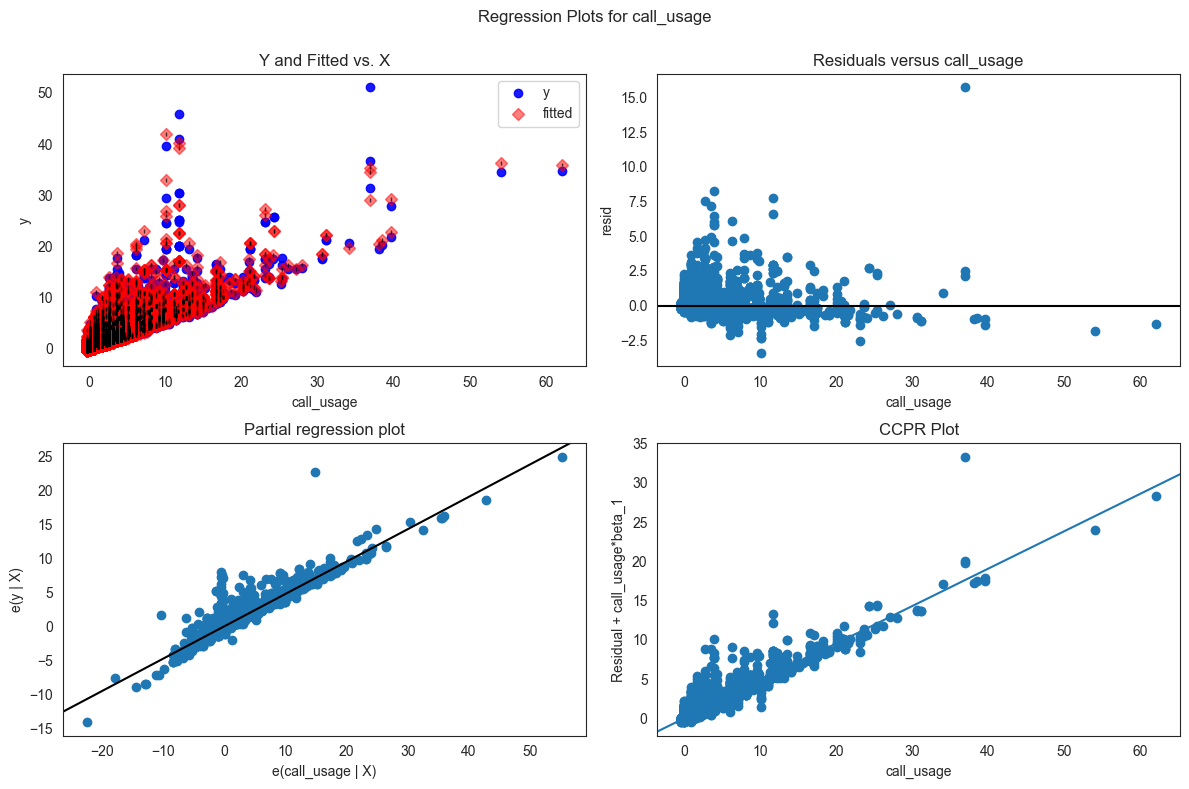

In [49]:
#define figure size
fig = plt.figure(figsize=(12,8))

#produce regression plots
fig = sm.graphics.plot_regress_exog(model, 'call_usage', fig=fig)

#### Let's examine the residual for calls. Note the lack of pattern in the scatter. We have some values that deviate, but we can always tune or select a new model. But, most values fall into the no pattern, indictating proper predictions with no overfitting. No heteroskedasticity. Residual plots are nice and linear, but not perfectly. 